In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from in_out.dataset_slice_detector import create_dataset
from config.config import config
from common.dslices.config import config as sd_config

from utils.dslices.exper_handler import ExperHandlerEnsemble, ExperimentHandler as ExperimentHandlerSD

from models.slice_detector import DegenerateSliceDetector
from utils.dslices.batch_handler import BatchHandler as BatchHandlerSD

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [41]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(sd_config.exper_dict_brier)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. 
TEST_FOLD = 0

exp_nomaps = {3: "",
              2: "",
              1: "",
              0: "20180828_16_32_02_sdvgg11_bn_f0p01_brier_nomap_4KE_lr5e05"}

if exp_nomaps[TEST_FOLD] != "":
    print("")
    print("----------- Load experiment {} ---------------".format(exp_nomaps[TEST_FOLD]))
    exp_nomaps_path = os.path.join(LOG_DIR, exp_nomaps[TEST_FOLD])

    exper_hdl_nomaps = ExperimentHandlerSD()
    exper_hdl_nomaps.set_seg_ensemble(seg_exper_ensemble)
    exper_hdl_nomaps.load_experiment(exp_nomaps_path, use_logfile=False)
    exper_hdl_nomaps.set_root_dir(ROOT_DIR)

    print("Model name: {}".format(exper_hdl_nomaps.model_name))

exp_umaps = {3: "",
             2: "",
             1: "",
             0: "20180828_16_44_03_sdvgg11_bn_f0p01_brier_umap_4KE_lr5e05"}

if exp_umaps[TEST_FOLD] != "":
    print("")
    print("----------- Load experiment {} ---------------".format(exp_umaps[TEST_FOLD]))
    exp_umaps_path = os.path.join(LOG_DIR, exp_umaps[TEST_FOLD])

    exper_hdl_umaps = ExperimentHandlerSD()
    exper_hdl_umaps.set_seg_ensemble(seg_exper_ensemble)
    exper_hdl_umaps.load_experiment(exp_umaps_path, use_logfile=False)
    exper_hdl_umaps.set_root_dir(ROOT_DIR)

    print("Model name: {}".format(exper_hdl_umaps.model_name))

exp_emaps = {3: "",
                2: "",
                1: "",
                0: "20180828_16_59_35_sdvgg11_bn_f0p01_brier_emap_4KE_lr5e05",    # lambda=7
                0.1: "20180828_15_50_18_sdvgg11_bn_f0p01_brier_emap_4KE_lr5e05"}  # lambda=5

if exp_emaps[TEST_FOLD] != "":
    print("----------- Load experiment {} ---------------".format(exp_emaps[TEST_FOLD]))
    exp_emaps_path = os.path.join(LOG_DIR, exp_emaps[TEST_FOLD])

    exper_hdl_emaps = ExperimentHandlerSD()
    exper_hdl_emaps.set_seg_ensemble(seg_exper_ensemble)
    exper_hdl_emaps.load_experiment(exp_emaps_path, use_logfile=False)
    exper_hdl_emaps.set_root_dir(ROOT_DIR)

    print("Model name: {}".format(exper_hdl_emaps.model_name))



Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier

----------- Load experiment 20180828_16_32_02_sdvgg11_bn_f0p01_brier_nomap_4KE_lr5e05 ---------------
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180828_16_32_

4000


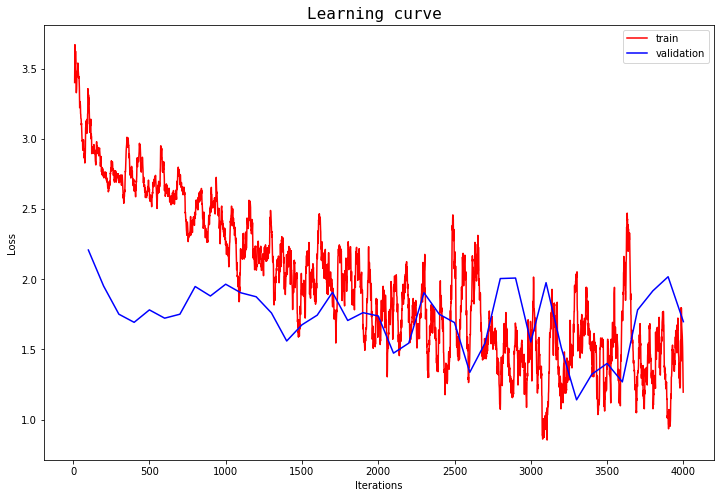

In [42]:
from plotting.learning_curves import loss_plot

loss_plot(exper_hdl_emaps.exper, height=8, width=12, save=False, show=True, validation=True,
              log_scale=False, do_average=True, window_size=25, epoch_range=None)

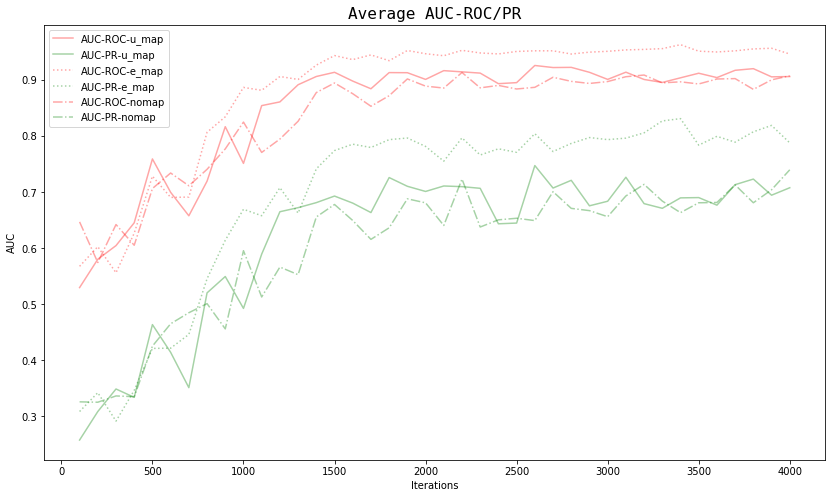

In [43]:
from plotting.dslices.classification_metrics import average_auc
expers = [exper_hdl_umaps.exper, exper_hdl_emaps.exper, exper_hdl_nomaps.exper]
average_auc(expers, fig_name=None, height=8, width=14, save=False, show=True)

In [3]:
sdvgg = exper_hdl_umaps.load_checkpoint(exper_hdl_umaps.exper.run_args.log_dir)

Creating new model DegenerateSliceDetector
Loading existing model with checkpoint 6000 from dir /home/jorg/repository/dcnn_acdc/logs/20180824_13_06_44_sdvgg11_bn_f1p01_brier_umap_6KE_lr1e05/checkpoints


In [42]:
sdvgg_l1 = exper_hdl_umaps_l1.load_checkpoint(exper_hdl_umaps_l1.exper.run_args.log_dir)

Creating new model DegenerateSliceDetector
Loading existing model with checkpoint 6000 from dir /home/jorg/repository/dcnn_acdc/logs/20180824_16_37_26_sdvgg11_bn_f1p01_brier_umap_6KE_lr1e05/checkpoints


In [ ]:
detect_dataset = create_dataset(TEST_FOLD, seg_exper_ensemble, type_of_map="u_map", degenerate_type="mean", 
                                pos_label=1)


In [59]:
exper_hdl_umaps_l1.test(data_set=detect_dataset, model=sdvgg_l1)

INFO - Begin test run 17
INFO - End test run 17 #slices=138: f1=0.797 - roc_auc=0.945 - pr_auc=0.955 - prec=0.959 - rec=0.681 - 0.93 seconds


In [65]:
test_id = exper_hdl_umaps.last_test_id

precision, recall, thresholds = exper_hdl_umaps.test_stats[test_id]["pr_curve"]
average_precision = exper_hdl_umaps.test_stats[test_id]["pr_auc"]

In [67]:
test_id = exper_hdl_umaps_l1.last_test_id

precision, recall, thresholds = exper_hdl_umaps_l1.test_stats[test_id]["pr_curve"]
average_precision = exper_hdl_umaps_l1.test_stats[test_id]["pr_auc"]

Text(0.5,1,u'2-class Precision-Recall curve: AP=0.96')

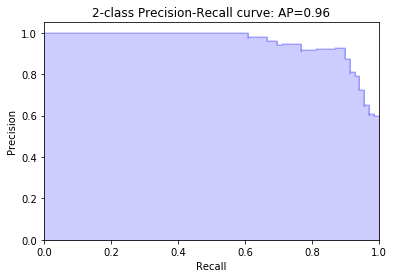

In [68]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))